In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [13]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
# Download
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gleni\.cache\kagglehub\datasets\aslanahmedov\walmart-sales-forecast\versions\1


In [14]:
df_train = pd.read_csv(path + "/train.csv")
df_test = pd.read_csv(path + "/test.csv")
df_stores = pd.read_csv(path + "/stores.csv")
df_features = pd.read_csv(path + "/features.csv")

In [16]:
df = df_train.merge(df_features, on=["Store", "Date"], how="inner").merge(df_stores, on=["Store"], how="inner")
df_test = df_test.merge(df_features, on=["Store", "Date"], how="inner").merge(df_stores, on=["Store"], how="inner")

In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [18]:
df['Week'] = df['Date'].dt.isocalendar().week
df_test['Week'] = df_test['Date'].dt.isocalendar().week

df['Day_of_week'] =df['Date'].dt.dayofweek
df_test['Day_of_week'] =df_test['Date'].dt.dayofweek

df['Month'] =df['Date'].dt.month 
df_test['Month'] =df_test['Date'].dt.month 

df['Year'] =df['Date'].dt.year
df_test['Year'] =df_test['Date'].dt.year

df['Day'] =df['Date'].dt.day 
df_test['Day'] =df_test['Date'].dt.day

In [19]:
train = df.drop(columns=['IsHoliday_x'])
test = df_test.drop(columns=['IsHoliday_x'])

In [20]:
train['IsHoliday_y'] = train['IsHoliday_y'].astype(int)
test['IsHoliday_y'] = test['IsHoliday_y'].astype(int)

In [21]:
train.drop(columns=['MarkDown4', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature'], inplace=True)

In [24]:
train['Type'] = train['Type'].map({'A': 1, 'B': 2, 'C': 3})
test['Type'] = test['Type'].map({'A': 1, 'B': 2, 'C': 3})

In [25]:
train

,Store,Dept,Date,Weekly_Sales,MarkDown1,MarkDown2,MarkDown3,MarkDown5,IsHoliday_y,Type,Size,Week,Day_of_week,Month,Year,Day
0,1,1,2010-02-05,24924.50,NaN,NaN,NaN,NaN,0,1,151315,5,4,2,2010,5
1,1,1,2010-02-12,46039.49,NaN,NaN,NaN,NaN,1,1,151315,6,4,2,2010,12
2,1,1,2010-02-19,41595.55,NaN,NaN,NaN,NaN,0,1,151315,7,4,2,2010,19
3,1,1,2010-02-26,19403.54,NaN,NaN,NaN,NaN,0,1,151315,8,4,2,2010,26
4,1,1,2010-03-05,21827.90,NaN,NaN,NaN,NaN,0,1,151315,9,4,3,2010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,4556.61,20.64,1.50,3288.25,0,2,118221,39,4,9,2012,28
421566,45,98,2012-10-05,628.10,5046.74,NaN,18.82,2340.01,0,2,118221,40,4,10,2012,5
421567,45,98,2012-10-12,1061.02,1956.28,NaN,7.89,3990.54,0,2,118221,41,4,10,2012,12
421568,45,98,2012-10-19,760.01,2004.02,NaN,3.18,1537.49,0,2,118221,42,4,10,2012,19


In [26]:
train.fillna(0, inplace=True)
#test.isnull().sum()

In [27]:
train['sample_weight'] = train['IsHoliday_y'].apply(lambda x: 5 if x == 1 else 1)

In [28]:
cutoff_date = '2011-12-31'
cutoff_date_val = '2012-06-30'

In [29]:
train_data = train[train['Date'] <= cutoff_date]
val_data = train[(train['Date'] > cutoff_date) & (train['Date'] <= cutoff_date_val)]
test_data = train[train['Date'] > cutoff_date_val]

In [30]:
# --- Training set
train_x = train_data.drop(columns=['Weekly_Sales', 'Date'])
train_y = train_data['Weekly_Sales'].values
train_weights = train_data['sample_weight'].values

# --- Validation set
val_x = val_data.drop(columns=['Weekly_Sales', 'Date'])
val_y = val_data['Weekly_Sales'].values
val_weights = val_data['sample_weight'].values

# --- Test set
test_x = test_data.drop(columns=['Weekly_Sales', 'Date'])
test_y = test_data['Weekly_Sales'].values
test_weights = test_data['sample_weight'].values

In [31]:
print(train_x.shape, train_y.shape, train_weights.shape)
print(val_x.shape, val_y.shape, val_weights.shape)
print(test_x.shape, test_y.shape, test_weights.shape)

(294132, 15) (294132,) (294132,)
(77110, 15) (77110,) (77110,)
(50328, 15) (50328,) (50328,)


In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
val_x_scaled = scaler.transform(val_x)
test_x_scaled = scaler.transform(test_x)

In [34]:
def create_sequences(x, y, weights, time_steps=5):
    X_seq, y_seq, w_seq = [], [], []
    for i in range(time_steps, len(x)):
        X_seq.append(x[i - time_steps:i])
        y_seq.append(y[i])
        w_seq.append(weights[i])  # weight for target time step
    return np.array(X_seq), np.array(y_seq), np.array(w_seq)

time_steps = 5
train_X, train_y, train_w = create_sequences(train_x_scaled, train_y, train_weights, time_steps)
val_X, val_y, val_w = create_sequences(val_x_scaled, val_y, val_weights, time_steps)

In [35]:
print(train_X.shape, train_y.shape, train_w.shape)
print(test_x_scaled.shape, test_y.shape, test_weights.shape)
print(val_X.shape, val_y.shape, val_w.shape)

(294127, 5, 15) (294127,) (294127,)
(50328, 15) (50328,) (50328,)
(77105, 5, 15) (77105,) (77105,)


In [36]:
from tensorflow.keras.losses import MeanAbsoluteError
loss_fn = MeanAbsoluteError()

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


model = Sequential([
    LSTM(64, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Regression
])

In [39]:
class R2ScoreCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred_train = self.model.predict(train_X, verbose=0).flatten()
        y_pred_val = self.model.predict(val_X, verbose=0).flatten()
        r2_train = r2_score(train_y, y_pred_train)
        r2_val = r2_score(val_y, y_pred_val)
        print(f"\nEpoch {epoch + 1}: R² Train = {r2_train:.4f}, R² Val = {r2_val:.4f}")


r2_callback = R2ScoreCallback()

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [41]:
history = model.fit(
    train_X, train_y,
    sample_weight=train_w,
    validation_data=(val_X, val_y, val_w),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, R2ScoreCallback()],
    verbose=1
)

Epoch 1/30
4596/4596 [==============================] - ETA: 0s - loss: 908069568.0000 - mae: 14488.0928WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 1: R² Train = 0.0068, R² Val = 0.0075
4596/4596 [==============================] - 70s 14ms/step - loss: 908069568.0000 - mae: 14488.0928 - val_loss: 581888768.0000 - val_mae: 14912.8662
Epoch 2/30
4585/4596 [============================>.] - ETA: 0s - loss: 686149248.0000 - mae: 13148.6602WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 2: R² Train = 0

In [50]:
test_x_scaled = scaler.transform(test_x)

# Create sequences from test data
test_X, test_y, test_w = create_sequences(test_x_scaled, test_y, test_weights, time_steps)

# Check shapes (optional)
print(test_X.shape, test_y.shape, test_w.shape)

(50323, 5, 15) (50323,) (50323,)


In [51]:
# Predict with the trained model
pred_y = model.predict(test_X, verbose=0).flatten()

In [52]:
mae = mean_absolute_error(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
r2 = r2_score(test_y, pred_y)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.4f}")

Test MAE: 8738.87
Test RMSE: 14696.40
Test R² Score: 0.5525


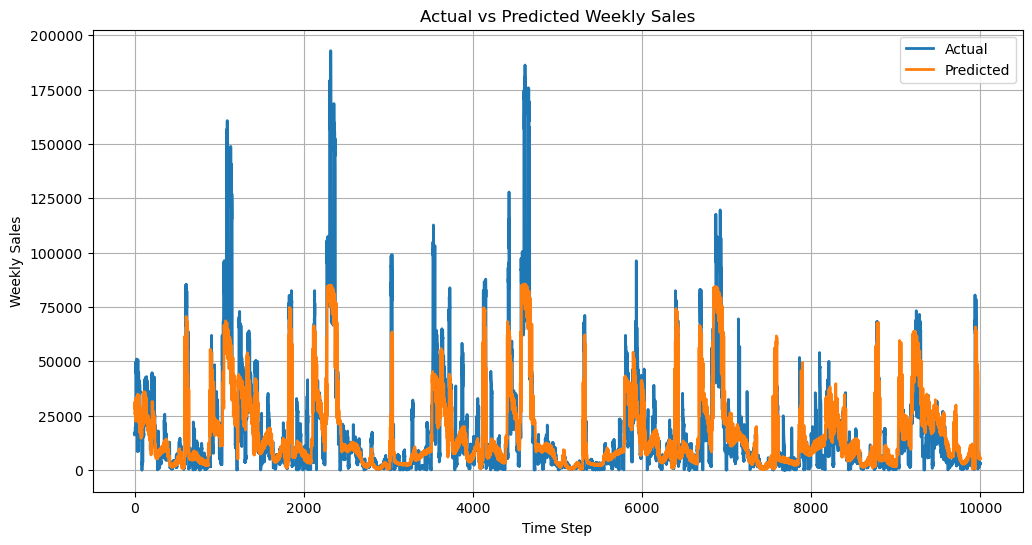

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_y[:10000], label='Actual', linewidth=2)
plt.plot(pred_y[:10000], label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Time Step')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid()
plt.show()

## This model fits the data slightly better than what we had before with no feature engeenering

In [56]:
model_2 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear') 
])

In [57]:
model_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [58]:
history_2 = model_2.fit(
    train_X, train_y,
    sample_weight=train_w,
    validation_data=(val_X, val_y, val_w),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, R2ScoreCallback()],
    verbose=1
)

Epoch 1/30
4591/4596 [============================>.] - ETA: 0s - loss: 894108416.0000 - mae: 14555.9121WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 1: R² Train = -0.0000, R² Val = -0.0004
4596/4596 [==============================] - 102s 21ms/step - loss: 894165312.0000 - mae: 14557.6719 - val_loss: 586314560.0000 - val_mae: 15208.3594
Epoch 2/30
4590/4596 [============================>.] - ETA: 0s - loss: 744617856.0000 - mae: 14301.0371WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 2: R² Train 

In [59]:
# Predict with the trained model
pred_y = model_2.predict(test_X, verbose=0).flatten()

In [60]:
mae = mean_absolute_error(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
r2 = r2_score(test_y, pred_y)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.4f}")

Test MAE: 9813.19
Test RMSE: 15274.05
Test R² Score: 0.5166


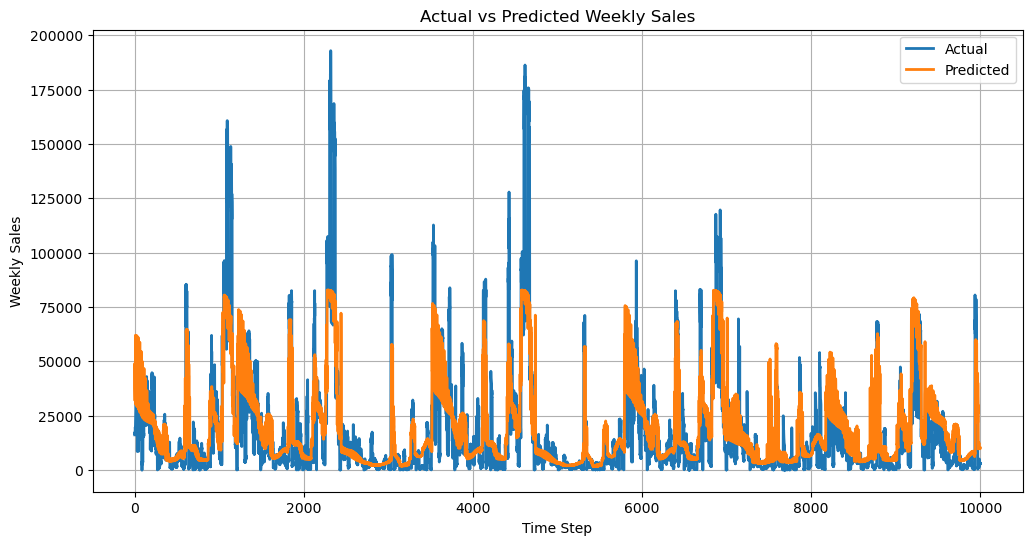

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_y[:10000], label='Actual', linewidth=2)
plt.plot(pred_y[:10000], label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Time Step')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid()
plt.show()